# 6. Target encoding

In this exercise, you'll apply target encoding to features in the Ames dataset.

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from category_encoders import MEstimateEncoder
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score



In [3]:
data_path="../../data/ames.csv.zip"

In [4]:
df=pd.read_csv(data_path)

In [5]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition,SalePrice
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,None,0.0,5,2010,WD,Normal,215000
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,None,0.0,6,2010,WD,Normal,105000
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,Gar2,12500.0,6,2010,WD,Normal,172000
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,None,0.0,4,2010,WD,Normal,244000
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,None,0.0,3,2010,WD,Normal,189900


First you'll need to choose which features you want to apply a target encoding to. Categorical features with a large number of categories are often good candidates. Run this cell to see how many categories each categorical feature in the *Ames* dataset has.

In [6]:
df.select_dtypes(["object"]).nunique()

MSSubClass       16
MSZoning          7
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         3
LotConfig         5
LandSlope         3
Neighborhood     28
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
OverallQual      10
OverallCond       9
RoofStyle         6
RoofMatl          8
Exterior1st      16
Exterior2nd      17
MasVnrType        5
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          6
BsmtCond          6
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        6
KitchenQual       5
Functional        8
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            5
Fence             5
MiscFeature       6
SaleType         10
SaleCondition     6
dtype: int64

We talked about how the **M-estimate encoding uses smoothing to improve estimates for rare categories**. To see how many times a category occurs in the dataset, you can use the `value_counts` method. This cell shows the counts for `SaleType`, but you might want to consider others as well.

In [7]:
df["SaleType"].value_counts()

WD       2536
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
VWD         1
Name: SaleType, dtype: int64

## 6.1 Choose Features for Encoding

Q1. Which features are suitable for target encoding?

```text
As we mentioned before, target encoding is good for categorical feature that contains many distinct values. So the `Neighborhood` feature looks promising. It has the most categories of any feature, and several categories are rare. Others that could be worth considering are `SaleType, MSSubClass, Exterior1st, Exterior2nd`. In fact, almost any of the nominal features would be worth trying because of the prevalence of rare categories.
```


Now you'll apply a target encoding to your choice of feature. As we discussed in the tutorial, to avoid overfitting, we need to fit the encoder on data heldout from the training set. Run this cell to create the encoding and training splits:

In [11]:
# Encoding split
X_encode = df.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop("SalePrice")

encode_row_num=X_encode.count(axis=0)
print(encode_row_num)


MSSubClass       586
MSZoning         586
LotFrontage      586
LotArea          586
Street           586
                ... 
MiscVal          586
MoSold           586
YearSold         586
SaleType         586
SaleCondition    586
Length: 78, dtype: int64


In [12]:
# Training split
X_pretrain = df.drop(X_encode.index)
y_train = X_pretrain.pop("SalePrice")

train_row_num=X_pretrain.count(axis=0)
print(train_row_num)

MSSubClass       2344
MSZoning         2344
LotFrontage      2344
LotArea          2344
Street           2344
                 ... 
MiscVal          2344
MoSold           2344
YearSold         2344
SaleType         2344
SaleCondition    2344
Length: 78, dtype: int64


## 6.2 Apply M-Estimate encoding

Apply a target encoding to your choice of categorical features. Also choose a value for the smoothing parameter `m` (any value is okay for a correct answer).

In [13]:
# build a encoder on a feature column that you want to encode, and choose a value m for rare value smoothing
encoder = MEstimateEncoder(cols=["Neighborhood"], m=5.0)

# Fit the encoder on the encoding split
encoder.fit(X_encode,y_encode)

# Encode the training split
X_train = encoder.transform(X_pretrain, y_train)



In [18]:
# now the neighborhood feature is a float type
X_train["Neighborhood"].head()

0    145341.336525
1    145341.336525
2    145341.336525
3    145341.336525
4    190227.242321
Name: Neighborhood, dtype: float64

If you'd like to see how the encoded feature compares to the target, you can run this cell:

Text(0.5, 0, 'SalePrice')

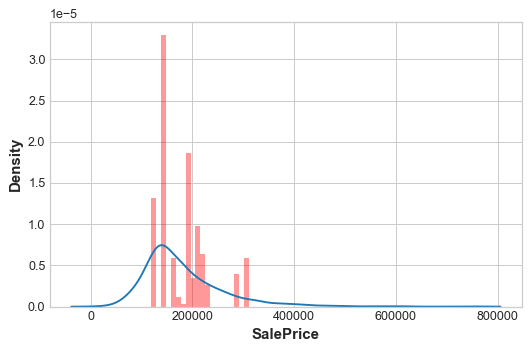

In [19]:
feature = encoder.cols

plt.figure(dpi=90)
ax = sns.distplot(y_train, kde=True, hist=False)
ax = sns.distplot(X_train[feature], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice")

From the distribution plots, does it seem like the encoding is informative?

And this cell will show you the score of the encoded set compared to the original set:

In [20]:
X = df.copy()
y = X.pop("SalePrice")
score_base = score_dataset(X, y)
score_new = score_dataset(X_train, y_train)

print(f"Baseline Score: {score_base:.4f} RMSLE")
print(f"Score with Encoding: {score_new:.4f} RMSLE")

Baseline Score: 0.1428 RMSLE
Score with Encoding: 0.1383 RMSLE


Do you think that target encoding was worthwhile in this case? Depending on which feature or features you chose, you may have ended up with a score significantly worse than the baseline. In that case, it's likely the extra information gained by the encoding couldn't make up for the loss of data used for the encoding.

## 6.3 Overfitting with Target Encoders

In this question, you'll explore the problem of **overfitting with target encodings**. This will illustrate this importance of training fitting target encoders on data held-out from the training set.

So let's see what happens when we fit the encoder and the model on the *same* dataset. To emphasize how dramatic the overfitting can be, we'll mean-encode a feature that should have no relationship with `SalePrice`, a count: `0, 1, 2, 3, 4, 5, ...`.

In [21]:
# Try experimenting with the smoothing parameter m
# Try 0, 1, 5, 50
m = 0

X = df.copy()
y = X.pop('SalePrice')

# Create an uninformative feature
X["Count"] = range(len(X))
X["Count"][1] = 0  # actually need one duplicate value to circumvent error-checking in MEstimateEncoder

# fit and transform on the same dataset
encoder = MEstimateEncoder(cols="Count", m=m)
X = encoder.fit_transform(X, y)

# Results
score =  score_dataset(X, y)
print(f"Score: {score:.4f} RMSLE")

Score: 0.0293 RMSLE


We get a perfect score (0.0293 RMSLE)

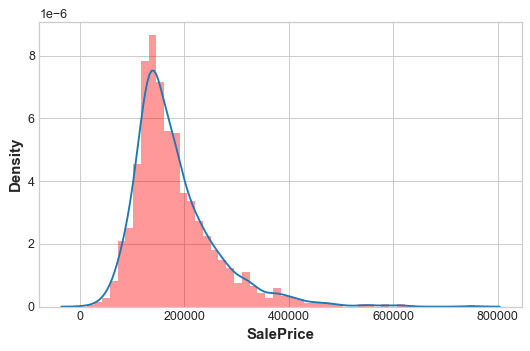

In [22]:
plt.figure(dpi=90)
ax = sns.distplot(y, kde=True, hist=False)
ax = sns.distplot(X["Count"], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");

And the distributions are almost exactly the same, too.

Q2. Based on your understanding of how mean-encoding works, can you explain how XGBoost was able to get an almost a perfect fit after mean-encoding the count feature?

Answers:

<mark>
Since Count never has any duplicate values, the mean-encoded Count is essentially
an exact copy of the target. In other words, mean-encoding turned a completely
meaningless feature into a perfect feature.

Now, the only reason this worked is because we trained XGBoost on the same set we used to train the encoder. If we had used a hold-out set instead, none of this "fake" encoding would have transferred to the training data.

The lesson is that when using a target encoder it's very important to use separate data sets for training the encoder and training the model. Otherwise the results can be very disappointing!
</mark>

# The End #

That's it for *Feature Engineering*! We hope you enjoyed your time with us.

Now, are you ready to try out your new skills? Now would be a great time to join our [Housing Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) Getting Started competition. We've even prepared a [Bonus Lesson](https://www.kaggle.com/ryanholbrook/feature-engineering-for-house-prices) that collects all the work we've done together into a starter notebook.

# References #
Here are some great resources you might like to consult for more information. They all played a part in shaping this course:
- *The Art of Feature Engineering*, a book by Pablo Duboue.
- *An Empirical Analysis of Feature Engineering for Predictive Modeling*, an article by Jeff Heaton.
- *Feature Engineering for Machine Learning*, a book by Alice Zheng and Amanda Casari. The tutorial on clustering was inspired by this excellent book.
- *Feature Engineering and Selection*, a book by Max Kuhn and Kjell Johnson.